### interpolateprawler_new - chu

In [139]:
import numpy as np
import datetime
import cmocean
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import pickle

In [2]:
with open('data/objs.pickle','rb') as f:  # Python 3 open(..., 'rb')
    df = pickle.load(f)

/Users/bell/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [220]:
df_drop=df
df_10min = df_drop.resample('10min').mean()
df_interp = df_10min.interpolate (method='time', limit=1)


# data coordinates and values
df_interp = df_interp.reset_index()

################################################
# if you want to use an integer as your x value, use
#   serial date / ordinal date. datetime.datetime.toordinal('yyyy-mm-dd')
#   Where 0001-01-01 is 1.  The ordinal function only works with integers 
#   so you will have to calculate the fractional day as well.
#  
x = [x.toordinal() + x.hour/24 + x.minute / 60 for x in df_interp.datetime64_ns]
df_interp['xi'] = x
################################################


#
#remove nan rows
df_interp = df_interp.dropna()

# data coordinates and values
df_interp = df_interp.reset_index()

x=df_interp.xi

y = df_interp.Depth
zt = df_interp.meantemp_lastminsampling
zs = df_interp.meansal_lastminsampling
zp = df_interp.pco2_corrected_osmotic
zo = df_interp.meano2_lastminsampling
zd = df_interp.sigmatheta_kgm_3
zpmod = df_interp.pco2_calculated_0_100

#setup xi grid based on x... use the first and last points and 
# add 10 min (10/3600): fractional day for each grid step
xi = np.arange(x[0],x[len(x)-1],10/3600)
yi = np.arange(0,90,2)

xi,yi = np.meshgrid(xi,yi)

k=1

# interpolate
zti = griddata((x,y/k),zt,(xi,yi),method='linear')
zsi = griddata((x,y/k),zs,(xi,yi),method='linear')
zpi = griddata((x,y/k),zp,(xi,yi),method='linear')
zoi = griddata((x,y/k),zo,(xi,yi),method='linear')
zdi = griddata((x,y/k),zd,(xi,yi),method='linear')
zpmodi = griddata((x,y/k),zpmod,(xi,yi),method='linear')


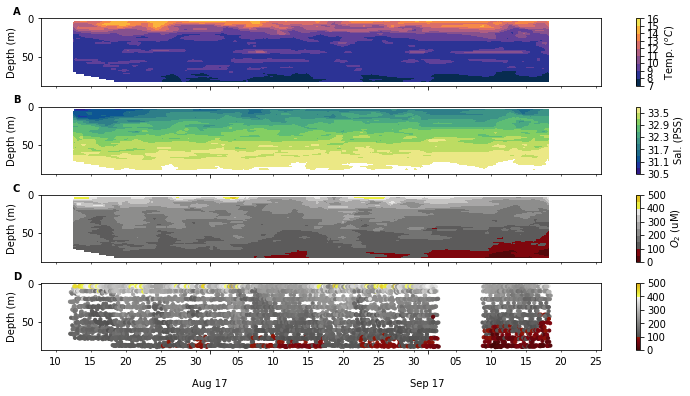

In [223]:
#make plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

im1 = ax1.contourf(xi,yi*k,zti,np.arange(7,17,1), cmap=cmocean.cm.thermal)
ax1.invert_yaxis()
cb1=fig.colorbar(im1, ax=ax1)
cb1.set_label('Temp. ($^oC$)')
dstop = datetime.datetime(2017,9,25, 18, 40)
dstart = datetime.datetime(2017,7,7, 21, 20)
ax1.set_xlim([dstart,dstop])

im2 = ax2.contourf(xi,yi*k,zsi,np.arange(30.5,34,0.3), cmap=cmocean.cm.haline)
ax2.invert_yaxis()
cb2=fig.colorbar(im2, ax=ax2)
cb2.set_label('Sal. (PSS)')
ax2.set_xlim([dstart,dstop])

im3=ax3.contourf(xi,yi*k,zoi,np.arange(0,525,50), cmap=cmocean.cm.oxy)
ax3.invert_yaxis()
cb3=fig.colorbar(im3, ax=ax3)
cb3.set_label('$O_2$ (uM)')
ax3.set_xlim([dstart,dstop])

df_interp.index = df_interp.datetime64_ns

im4 = ax4.scatter(df_interp.xi, df_interp.Depth, s=10, c=df_interp.meano2_lastminsampling, cmap=cmocean.cm.oxy,vmin=0, vmax=500)
ax4.invert_yaxis()
cb4=fig.colorbar(im4, ax=ax4)
ax4.set_xlim([dstart,dstop])

#fig.autofmt_xdate()
fig.set_size_inches(10.5, 5.5)

### Format Axis
# Turn off formating on all but bottom plot
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax2.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax3.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
ax4.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax4.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
ax4.xaxis.set_major_formatter(ticker.NullFormatter())
ax4.xaxis.set_minor_formatter(DateFormatter('%d'))
ax4.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax4.xaxis.set_tick_params(which='major', pad=25)
ax4.xaxis.set_tick_params(which='minor', pad=5)


# Set common labels
ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Depth (m)')
ax3.set_ylabel('Depth (m)')
ax4.set_ylabel('Depth (m)')

ax1.annotate("A", xy=(-0.05, 1.05), xycoords="axes fraction", weight='bold')
ax2.annotate("B", xy=(-0.05, 1.05), xycoords="axes fraction", weight='bold')
ax3.annotate("C", xy=(-0.05, 1.05), xycoords="axes fraction", weight='bold')
ax4.annotate("D", xy=(-0.05, 1.05), xycoords="axes fraction", weight='bold')

plt.tight_layout()
plt.savefig('interpolatedprawler_TSDO.png',dpi=100)